#### CSCA 5642 Introduction to Deep Learning
# CNN Cancer Detection Kaggle Mini-Project

***

## Brief Description of the Problem and Data (5 pts)
The challenge is to detect the presence of metastatic cancer in small image patches extracted from larger digital pathology scans. This task is critical in medical diagnostics, as early detection of cancer can significantly improve treatment outcomes. To address this challenge, a **Convolutional Neural Network (CNN)** will be employed due to its effectiveness in image analysis and pattern recognition.

The data is sourced from the [Histopathologic Cancer Detection Dataset](https://www.kaggle.com/c/histopathologic-cancer-detection/data), which includes both training and test sets. The training set comprises **220,025 images**, each with a resolution of **96x96 pixels**, along with labels indicating the presence ('1') or absence ('0') of cancer. These images, stored in TIFF format, are extracted from larger whole slide images and represent diverse tissue structures and staining variations. The test set consists of unlabeled images that will be used to evaluate the model's performance.


***
## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Let's do EDA for finding unexpected discoveries and clean it for accurate analysis. It will **include a few visualizations such as bar plot and showing sample images. After the EDA, we will discuss about a plan of analysis for building a model.**


In [3]:
import os
print(os.listdir('/kaggle/input/histopathologic-cancer-detection'))

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


In [4]:
# Import Libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

In [5]:
# Constants
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3
BASE_DIR = '/kaggle/input/histopathologic-cancer-detection'
TRAIN_LABEL_PATH = f"{BASE_DIR}/train_labels.csv"
TRAIN_IMAGE_PATH = f"{BASE_DIR}/train"
TEST_IMAGE_PATH = f"{BASE_DIR}/test"

# Load data
df_train_all = pd.read_csv(TRAIN_LABEL_PATH)
df_train_all.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
df_train_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


We observe that the **dataset consists of 220,025 labeled images with no missing values**.

To clarification, let's plot the class distribution to understand more.

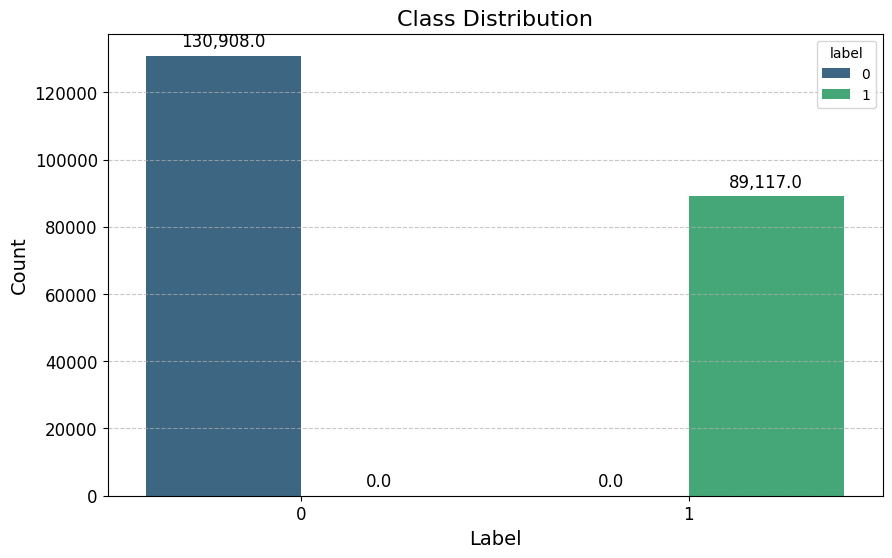

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df_train_all, palette='viridis', hue='label')
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add labels on top of the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():,}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       fontsize=12, color='black', 
                       xytext=(0, 10), 
                       textcoords='offset points')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

As you see the plot above, the lable data has around 130K numbers of non-cancerous (0) and 89K numbers of cancerous (1) images.

For further investigating of the data, **we will visualize a few sample images from each class**.

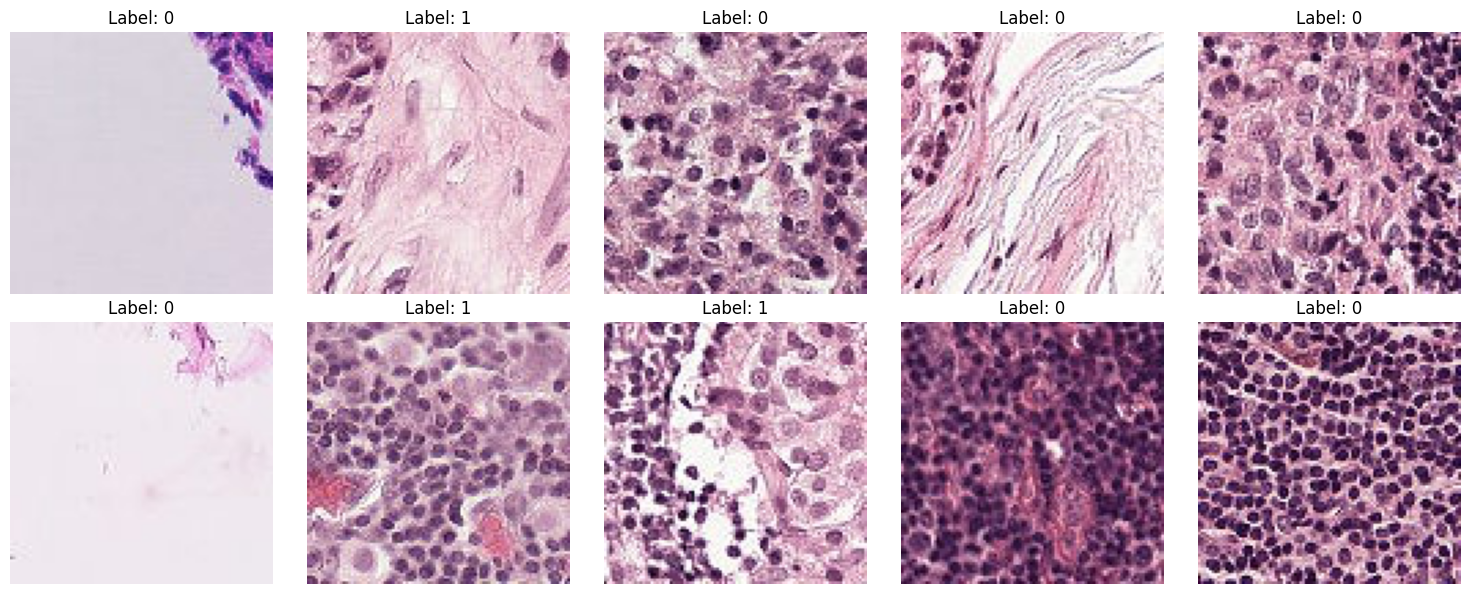

In [8]:
from PIL import Image

def show_images(image_ids, labels, ncols=5):
    nrows = len(image_ids) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))
    for ax, img_id in zip(axes.flatten(), image_ids):
        img_path = f'{TRAIN_IMAGE_PATH}/{img_id}.tif'
        image = Image.open(img_path)
        ax.imshow(image)
        ax.set_title(f'Label: {labels.loc[labels.id == img_id, "label"].values[0]}')
        ax.axis('off')
    plt.tight_layout()

# Display sample images
sample_ids = df_train_all.sample(10)['id'].values
show_images(sample_ids, df_train_all)


# Plan of analysis
Based on our exploratory data analysis we did so far, the plan for analysis includes:

- We are going to use a custom Pytorch Dataset to load the data gradually as the images are too many. 
- Model Building: Construct a Convolutional Neural Network (CNN) to classify the images.
- Model Training: Train the model using the dataset.
- Evaluation: Evaluate the model performance

By following this plan, we aim to build a robust model capable of accurately detecting metastatic cancer in histopathologic images.


# Model Architecture (25 pts)

Our model architecture is designed to detect metastatic cancer in small image patches effectively. We start by creating the `CancerDataset` class, which handles the training, validation, and test datasets. This class inherits from `torch.utils.data.Dataset` and implements the `__len__` and `__getitem__` methods to manage the loading of images and labels.

The core of our approach is a convolutional neural network (CNN) model implemented using PyTorch. The CNNModel class architecture is specifically tailored for cancer detection and consists of the following components:

- **Two Variants of Convolutional Layers**: We use two models, one with three convolutional layers and one with five convolutional layers. Each layer in both models applies convolution operations with ReLU activation functions and max pooling. These layers are crucial for extracting hierarchical features from the images, such as edges, textures, and more complex patterns relevant to cancer detection.
- **Two Fully Connected Layers**: These layers, along with dropout for regularization, are included to learn non-linear combinations of the extracted features, providing the model with the capability to make final classification decisions.

The specific architecture balances complexity and performance. Simpler models were insufficient to capture the necessary features, while more complex models tended to overfit the training data. By carefully tuning hyperparameters, such as the number of convolutional layers, filter sizes, and dropout rates, we achieved an optimal balance that allows the model to learn intricate patterns without overfitting.

Empirical results guided the choice of model parameters, including input shape, initial filters, and dropout rates. The model is optimized using the Adam optimizer, known for its efficiency and robustness, and a learning rate scheduler adjusts the learning rate based on validation loss, ensuring stable and effective training.

The training process is managed by the train_val function, which trains and validates the model, saving the best model weights and tracking the training history to ensure the highest performance. The model is also moved to a GPU if available, accelerating computation and enabling the handling of large datasets efficiently.

This architecture and its reasoning ensure that the CNN can effectively learn from the diverse and complex dataset, making it suitable for the problem of detecting metastatic cancer in pathology images.

In [9]:
import cv2  # OpenCV import
from torch.utils.data import Dataset
import torch

torch.manual_seed(0) # fix random seed

class CancerDataset(Dataset):
    
    def __init__(self, data_dir, transform, data_type="train"):
        self.data_dir = data_dir
        self.data_type = data_type
        self.transform = transform
        self.label_file = "train_labels.csv" if data_type=="train" else "sample_submission.csv"

        # Get Image File Names
        dataset_dir = os.path.join(data_dir, data_type)
        self.file_names = os.listdir(dataset_dir)
        self.full_file_paths = [os.path.join(dataset_dir, f) for f in self.file_names]

        # Get Labels
        labels_file = os.path.join(data_dir, self.label_file)
        labels_df = pd.read_csv(labels_file)
        labels_df.set_index("id", inplace=True)
        
        # Extract labels for selected file names
        self.labels = [labels_df.loc[os.path.splitext(filename)[0]].values[0] for filename in self.file_names]

    def __len__(self):
        return len(self.full_file_paths)

    def __getitem__(self, idx):
        # Open image, apply transforms, and return with label
        image = cv2.imread(self.full_file_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

We then define a transformation pipeline to convert images to tensors.

In [10]:
# The transform function
import torchvision.transforms as transforms
image_to_tensor_transformer = transforms.Compose([
    transforms.ToTensor(),
])

We initialize the dataset and create data loaders for training and validation sets.

In [11]:
cancer_dataset = CancerDataset(BASE_DIR, image_to_tensor_transformer)

In [12]:
from torch.utils.data import random_split

# Calculate dataset lengths
total_images = len(cancer_dataset)
train_size = int(0.8 * total_images)
val_size = total_images - train_size

# Split dataset into training and validation sets
train_dataset, val_dataset = random_split(cancer_dataset, [train_size, val_size])

# Print dataset sizes
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))


Training dataset size: 176020
Validation dataset size: 44005


In [13]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset,
                      batch_size=32, 
                      num_workers=4,
                      pin_memory=True)

val_loader = DataLoader(val_dataset,
                    batch_size=32,
                    num_workers=4,
                    pin_memory=True)


Finally, we define two CNN model classes, specifying the structure of the network.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

def find_conv2d_out_shape(height, width, conv_layer, pool=2):
    """Calculate the output shape of a Conv2D layer with optional pooling."""
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation

    height_out = np.floor((height + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    width_out = np.floor((width + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

    if pool:
        height_out /= pool
        width_out /= pool

    return int(height_out), int(width_out)


class CNNModel_v1(nn.Module):
    """Neural Network with 3 Conv2D layers."""
    def __init__(self, params):
        super(CNNModel_v1, self).__init__()
        # Extract parameters
        channels_in, height_in, width_in = params["shape_in"]
        initial_filters = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(channels_in, initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height_in, width_in, self.conv1)
        
        self.conv2 = nn.Conv2d(initial_filters, 2 * initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height, width, self.conv2)
        
        self.conv3 = nn.Conv2d(2 * initial_filters, 4 * initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height, width, self.conv3)
        
        # Compute the flattened size
        self.num_flatten = height * width * 4 * initial_filters
        
        # Define fully connected layers
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        
    def forward(self, x):
        """Forward pass through the network."""
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [15]:
class CNNModel_v2(nn.Module):
    """Neural Network with 5 Conv2D layers."""
    # Similar to CNNModel, but with an additional convolutional layer.
    def __init__(self, params):
        super(CNNModel_v2, self).__init__()
        # Extract parameters
        channels_in, height_in, width_in = params["shape_in"]
        initial_filters = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(channels_in, initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height_in, width_in, self.conv1)
        
        self.conv2 = nn.Conv2d(initial_filters, 2 * initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height, width, self.conv2)
        
        self.conv3 = nn.Conv2d(2 * initial_filters, 4 * initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height, width, self.conv3)
        
        self.conv4 = nn.Conv2d(4 * initial_filters, 8 * initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height, width, self.conv4)
        
        self.conv5 = nn.Conv2d(8 * initial_filters, 16 * initial_filters, kernel_size=3)
        height, width = find_conv2d_out_shape(height, width, self.conv5)
        
        # Compute the flattened size
        self.num_flatten = height * width * 16 * initial_filters
        
        # Define fully connected layers
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        
    def forward(self, x):
        """Forward pass through the network."""
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, self.num_flatten)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

We define the parameters for the CNN model and move the model to the GPU if available.

In [16]:
# Parameters
params_model={
        "shape_in": (3,96,96), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

cnn_model_1 = CNNModel_v1(params_model)
cnn_model_2 = CNNModel_v2(params_model)

# Hardware settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model_1 = cnn_model_1.to(device)
cnn_model_2 = cnn_model_2.to(device)

In [17]:
loss_func = nn.NLLLoss(reduction="sum")

In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim

optimizer = optim.Adam(cnn_model_1.parameters(), lr=3e-4)

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 20,
 "optimizer": optimizer,
 "lr_change": ReduceLROnPlateau(optimizer,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

We define the training and validation loop and train the model using the specified parameters.

In [19]:
import os
import time
from tqdm.notebook import trange, tqdm
import copy
import torch

def train_val(model, params, verbose=False):
    # Extract parameters
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    optimizer = params["optimizer"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Initialize history dictionaries and best model weights
    loss_history = {"train": [], "val": []}
    metric_history = {"train": [], "val": []}
    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    def get_current_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']
    
    def loss_epoch(model, loss_func, dataloader, optimizer=None):
        running_loss = 0.0
        running_metric = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            if optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_metric += (outputs.argmax(1) == labels).sum().item()
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_metric = running_metric / len(dataloader.dataset)
        return epoch_loss, epoch_metric
    
    # Training and validation loop
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        epoch_start_time = time.time()
        current_lr = get_current_lr(optimizer)
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Current Learning Rate: {current_lr:.6f}")
        
        # Training phase
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, optimizer)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), weight_path)
            if verbose:
                print("Best model weights updated.")
        
        # Adjust learning rate
        lr_scheduler.step(val_loss)
        if current_lr != get_current_lr(optimizer):
            if verbose:
                print("Learning rate changed, loading best model weights.")
            model.load_state_dict(best_model_weights)
        
        if verbose:
            print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_metric * 100:.2f}%")
            print(f"Validation Loss: {val_loss:.6f} | Validation Accuracy: {val_metric * 100:.2f}%")
            print("-" * 50)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    
    return model, loss_history, metric_history


In [20]:
cnn_model_1, loss_hist ,metric_hist=train_val(cnn_model_1, params_train, True)

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Current Learning Rate: 0.000300
Best model weights updated.
Train Loss: 14.581329 | Train Accuracy: 79.24%
Validation Loss: 12.933799 | Validation Accuracy: 81.78%
--------------------------------------------------
Epoch 1 completed in 491.11 seconds
Epoch 2/20
Current Learning Rate: 0.000300
Best model weights updated.
Train Loss: 12.111215 | Train Accuracy: 83.48%
Validation Loss: 11.441203 | Validation Accuracy: 84.84%
--------------------------------------------------
Epoch 2 completed in 88.96 seconds
Epoch 3/20
Current Learning Rate: 0.000300
Best model weights updated.
Train Loss: 11.262566 | Train Accuracy: 84.94%
Validation Loss: 10.872428 | Validation Accuracy: 85.78%
--------------------------------------------------
Epoch 3 completed in 95.38 seconds
Epoch 4/20
Current Learning Rate: 0.000300
Best model weights updated.
Train Loss: 10.647680 | Train Accuracy: 85.88%
Validation Loss: 10.387487 | Validation Accuracy: 86.59%
-----------------------------------------

In [21]:
optimizer = optim.Adam(cnn_model_2.parameters(), lr=3e-4)

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 20,
 "optimizer": optimizer,
 "lr_change": ReduceLROnPlateau(optimizer,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

cnn_model_2, loss_hist_2 ,metric_hist_2=train_val(cnn_model_2, params_train, True)

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Current Learning Rate: 0.000300
Best model weights updated.
Train Loss: 14.491191 | Train Accuracy: 79.22%
Validation Loss: 12.651496 | Validation Accuracy: 82.94%
--------------------------------------------------
Epoch 1 completed in 98.37 seconds
Epoch 2/20
Current Learning Rate: 0.000300
Best model weights updated.
Train Loss: 12.129826 | Train Accuracy: 83.35%
Validation Loss: 11.418323 | Validation Accuracy: 84.74%
--------------------------------------------------
Epoch 2 completed in 91.00 seconds
Epoch 3/20
Current Learning Rate: 0.000300
Best model weights updated.
Train Loss: 11.160430 | Train Accuracy: 84.97%
Validation Loss: 10.856120 | Validation Accuracy: 85.80%
--------------------------------------------------
Epoch 3 completed in 91.05 seconds
Epoch 4/20
Current Learning Rate: 0.000300
Best model weights updated.
Train Loss: 10.472795 | Train Accuracy: 86.03%
Validation Loss: 10.356861 | Validation Accuracy: 86.67%
------------------------------------------

# Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped. Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

## Visualizations
We plot the training and validation loss and accuracy over epochs.

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')

def plot_results(model_number, loss_hist, metric_hist):

    # Set seaborn style
    sns.set(style='whitegrid')

    # Extract the number of epochs
    epochs = params_train["epochs"]

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot loss history
    sns.lineplot(x=range(1, epochs + 1), y=loss_hist["train"], ax=ax[0], label='Train Loss')
    sns.lineplot(x=range(1, epochs + 1), y=loss_hist["val"], ax=ax[0], label='Validation Loss')
    ax[0].set_title('Loss History')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plot metric history
    sns.lineplot(x=range(1, epochs + 1), y=metric_hist["train"], ax=ax[1], label='Train Accuracy')
    sns.lineplot(x=range(1, epochs + 1), y=metric_hist["val"], ax=ax[1], label='Validation Accuracy')
    ax[1].set_title('Metric History')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].legend()

    # Set the main title
    fig.suptitle(f"Convergence History - Model # {model_number}", fontsize=16)

    # Show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


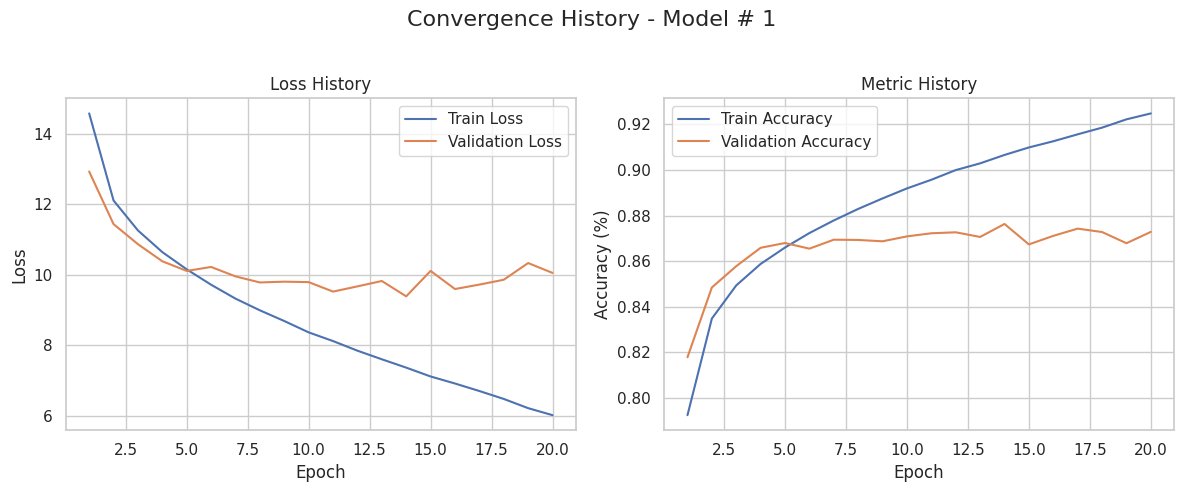

In [26]:
plot_results(1, loss_hist, metric_hist)

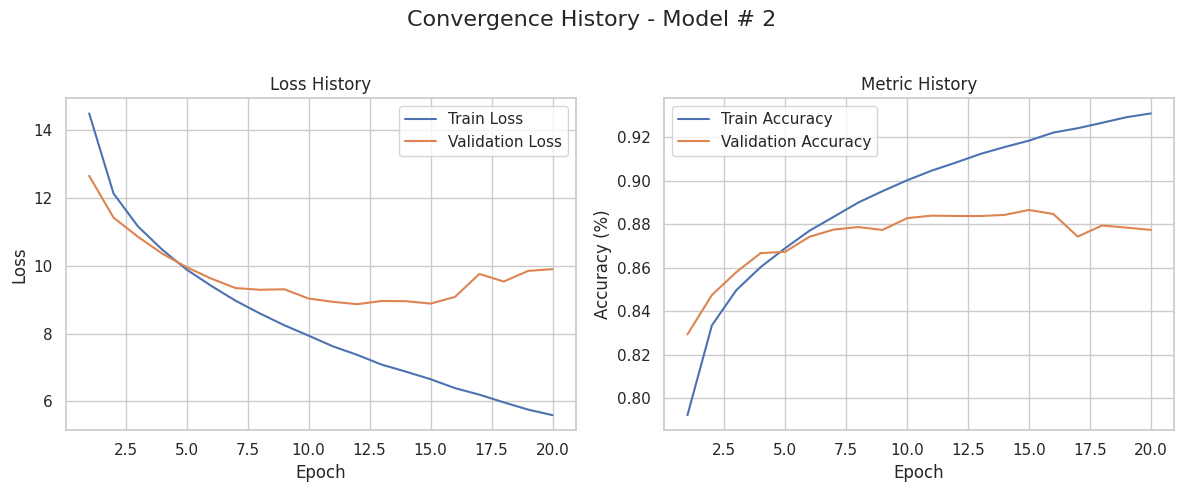

In [27]:
plot_results(2, loss_hist_2, metric_hist_2)

## Model Comparison / Troubleshooting procedure

The two models with different conv2 layers have similar performance, but model 2, which has 5 conv2 layers, exhibits a slightly higher validation accuracy (best: 88.66%) than model 1. Therefore, we will use model 2 to perform predictions on the test dataset and submit the results to Kaggle.

During the training process, the training time was a significant issue. To improve the training time, I closely monitored the CPU/GPU usage and found that the bottleneck might be in the CPU due to the image loading process. I looked up resources online to improve this aspect. Subsequently, I used `num_workers=4` and `pin_memory=True` in the data loaders to speed up the CPU processing time and used OpenCV for more efficient image reading.

# Conclusion (15 pts)

In this section, we discuss and interpret the results, as well as share learnings and takeaways. We analyze what improved the performance of our models, what didn't, and suggest future improvements.

## 1. Results Overview:

Model 2 outperformed Model 1 due to the inclusion of more convolutional layers, which allowed it to capture more complex patterns and features from the images.

## 2. Learnings and Takeaways:

- Training on a CPU was extremely inefficient and time-consuming, making it impractical for this assignment. Using a personal laptop proved to be insufficient for the computational demands of training these models.
- Utilizing platforms like Google Colab or Kaggle, which offer GPU resources, significantly improves training efficiency and reduces setup time.

## 3. Challenges:

Training on a CPU was nearly impossible to complete the assignment in a reasonable timeframe. Even with GPU resources, training the models took a considerable amount of time, leaving limited time for hyperparameter tuning and experimentation.

## 4. Future Improvements:

To improve the process, I need to better utilize sampling techniques for model selection and hyperparameter tuning. This would help in efficiently identifying the best model configurations without exhaustive manual trials.

# Submission

For submittion, we will run the best model on the test dataset and created a .csv file with id and predicted lables.

We initialize the test dataset and print the number of test samples.

In [30]:
cancer_dataset_test = CancerDataset(BASE_DIR, image_to_tensor_transformer, data_type='test')
print(len(cancer_dataset_test))

57458


We define a function to perform inference on the test dataset and then use this function to make predictions.

In [31]:
def inference(model, dataset, device, num_classes=2):
    len_data = len(dataset)
    y_out = torch.zeros(len_data, num_classes, device=device)  # initialize output tensor on device
    y_gt = np.zeros(len_data, dtype="uint8")  # initialize ground truth

    model = model.to(device)  # move model to device

    with torch.no_grad():
        for i in tqdm(range(len_data), desc="Inference Progress"):
            x, y = dataset[i]
            y_gt[i] = y
            y_out[i] = model(x.unsqueeze(0).to(device))

    return y_out.cpu().numpy(), y_gt

# Perform inference
y_test_out, _ = inference(cnn_model_2, cancer_dataset_test, device)

# Class predictions (0, 1)
y_test_pred = np.argmax(y_test_out, axis=1)
print(y_test_pred.shape)
print(y_test_pred[:5])

# Probabilities of predicted class
preds = np.exp(y_test_out[:, 1])
print(preds.shape)
print(preds[:5])

Inference Progress:   0%|          | 0/57458 [00:00<?, ?it/s]

(57458,)
[0 0 0 0 0]
(57458,)
[0.350545   0.07823949 0.0420494  0.12464559 0.05953739]


In [32]:
import pandas as pd

# Assuming img_dataset_test has a method to get ids or filenames
# This is a mock function to simulate getting IDs from the dataset
def get_image_ids(dataset):
    file_names= dataset.file_names
    return [file_names[i].split('.')[0] for i in range(len(file_names))]

# Get the image IDs
image_ids = get_image_ids(cancer_dataset_test)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    "id": image_ids,
    "label": preds
})

# Write the results to a CSV file
results_df.to_csv('submission.csv', index=False)

In [33]:
results_df

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.350545
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.078239
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.042049
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.124646
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.059537
...,...,...
57453,7907c88a7f5f9c8ca5b2df72c1e6ff9650eea22b,0.056846
57454,2a6fc1ed16fa94d263efab330ccbeb1906cbd421,0.006658
57455,6bb5c0611c0ccf4713e0ccbc0e8c54bcb498ef14,0.748127
57456,f11e7c9e77cbc1ec916a52e6b871a293ee1bb928,0.009642
